In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import json
from anytree.importer import JsonImporter
from anytree import PreOrderIter

In [2]:
from scipy import stats
from scipy.stats import ttest_rel,ttest_ind,mannwhitneyu,normaltest,shapiro,sem

import statsmodels.api as sm
import pylab as py

In [3]:
# Set the style to remove top and right borders
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# set the font size
plt.rcParams.update({'font.size': 11})
# remove legend edge
plt.rcParams['legend.frameon'] = False

In [4]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
map_dir = 'active_map/'
# data_dir  = 'data/preprocessed'
# out_dir = home_dir + 'figures/cogsci_2022/'
out_dir2 = home_dir + 'stat_model/'
R_out_dir = home_dir + 'R_analysis_data/'

In [57]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv')
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv')

data_choice_level['sqrt_leftover'] = np.sqrt(data_choice_level.leftover)
puzzleID_order_data['sqrt_nos'] = np.sqrt(puzzleID_order_data.nos)
puzzleID_order_data['log_RT1'] = np.log(puzzleID_order_data.RT1)

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index()
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index()

with open(home_dir +'tree_data/undo_tree', 'r') as file:
    undo_tree = json.load(file)

In [58]:
sc_data_choice_level

,index,Unnamed: 0.1,Unnamed: 0,subjects,puzzleID,trialID,allMAS,path,choice,currNumCities,...,submit,checkEnd,severityOfErrors,error,RT,undoRT,tortuosity,branching,branchingFirst,sqrt_leftover
0,0,0,0,0,27,0,11,[0],0,1,...,0,0,0,0,-1,NaN,0.000000,NaN,NaN,17.320508
1,1,1,1,0,27,0,11,"[0, 15]",15,2,...,0,0,0,0,5770,NaN,1.000000,NaN,NaN,16.240408
2,2,2,2,0,27,0,11,"[0, 15, 24]",24,3,...,0,0,0,0,1311,NaN,1.130933,NaN,NaN,15.701790
3,3,3,3,0,27,0,11,"[0, 15, 24, 17]",17,4,...,0,0,0,0,1263,NaN,1.128554,NaN,NaN,15.165529
4,4,4,4,0,27,0,11,"[0, 15, 24, 17, 12]",12,5,...,0,0,0,0,3639,NaN,1.256188,NaN,NaN,14.792327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67928,111883,111883,111883,99,30,68,8,"[0, 16, 25, 27, 3]",3,5,...,0,0,0,0,918,NaN,1.068325,NaN,NaN,7.511292
67929,111884,111884,111884,99,30,68,8,"[0, 16, 25, 27, 3, 29]",29,6,...,0,0,0,0,810,NaN,1.076896,NaN,NaN,6.149670
67930,111885,111885,111885,99,30,68,8,"[0, 16, 25, 27, 3, 29, 18]",18,7,...,0,0,0,0,1033,NaN,1.152506,NaN,NaN,4.301770
67931,111886,111886,111886,99,30,68,8,"[0, 16, 25, 27, 3, 29, 18, 5]",5,8,...,0,1,0,0,903,NaN,1.218016,NaN,NaN,2.338124


In [7]:
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y


single_condition_data['sqrt_leftover'] = np.sqrt(single_condition_data.leftover)
single_condition_data['sqrt_numFullUndo'] = np.sqrt(single_condition_data.numFullUndo)
# single_condition_data['percentile_numFullUndo'] = single_condition_data.numFullUndo.rank(method='min')

In [9]:
# helper functions
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# add p-value to figure
def text(p):
    if p == 0:
        axs.text((x1+x2)*.5, y+h,  r"$p = {:.1f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    elif p < 0.001:
        axs.text((x1+x2)*.5, y+h, r"$p = {0:s}$".format(as_si(p,1)), ha='center', va='bottom', color=col, fontsize = 8)
    elif p > 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.2f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

    elif 0.01 < p < 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.3f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    else:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.4f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

# MAS gain

In [225]:
mas_gain_df = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','error_beginning','mas_gain'])

for sub in range(101):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
        # all last undo
        lastUndo_idx = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            # get cumulative error at undo beginning
            cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
            cum_error_beginning_list.append(cum_error_beginning)
            error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
            error_beginning_list.append(error_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # use each value in cum_error_beginning_list to subtract accu_severity_error
        mas_gain = []
        for i in range(len(cum_error_beginning_list)):
            mas_gain.append(cum_error_beginning_list[i] - accu_severity_error[i])
        
        
        # if category is not empty, add it to an empty dataframe
        if len(mas_gain) > 0:
            mas_gain_df = pd.concat([mas_gain_df,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                 'mas_gain':mas_gain})])


In [226]:
mas_gain_df_sub = mas_gain_df.groupby(['subjects','mas_gain']).count().reset_index()
mas_gain_df_sub

,subjects,mas_gain,puzzleID,cum_error_beginning,error_beginning
0,0,0,2,2,2
1,0,1,7,7,7
2,0,2,1,1,1
3,0,3,1,1,1
4,1,0,6,6,6
...,...,...,...,...,...
314,99,0,7,7,7
315,99,1,9,9,9
316,99,2,7,7,7
317,99,3,2,2,2


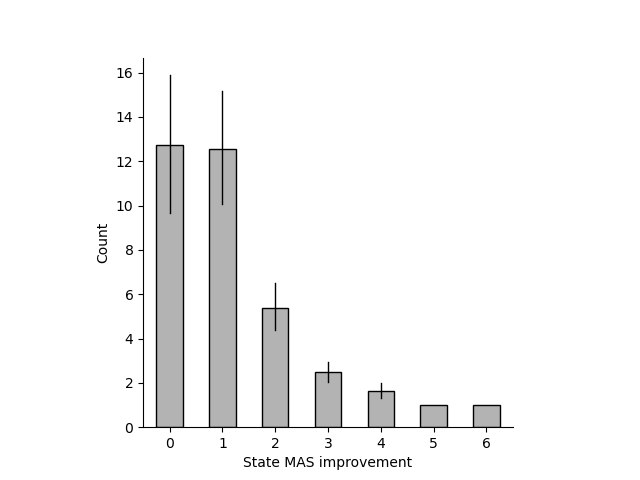

,mas_gain,subjects
0,0,82
1,1,84
2,2,73
3,3,50
4,4,25
5,5,4
6,6,1


In [237]:
# plot accu_error_sub as sns barplot
%matplotlib widget

fig, axs = plt.subplots(1,1)
sns.barplot(x = 'mas_gain', y = 'puzzleID', data = mas_gain_df_sub, 
            color = [.7,.7,.7],
            width=.5, linewidth=1,
            # error bar parameters
            errwidth = 1,
            errcolor = 'k',
            edgecolor = 'k',
            ax = axs)

axs.set(xlabel='State MAS improvement', ylabel='Count')

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
mas_gain_df_sub.groupby(['mas_gain'])['subjects'].count().reset_index()

In [238]:
mas_gain_df_sub = mas_gain_df.groupby(['subjects','cum_error_beginning']).count().reset_index()
mas_gain_df_sub

,subjects,cum_error_beginning,puzzleID,error_beginning,mas_gain
0,0,0,2,2,2
1,0,1,6,6,6
2,0,2,2,2,2
3,0,3,1,1,1
4,1,1,11,11,11
...,...,...,...,...,...
325,99,0,4,4,4
326,99,1,11,11,11
327,99,2,8,8,8
328,99,3,2,2,2


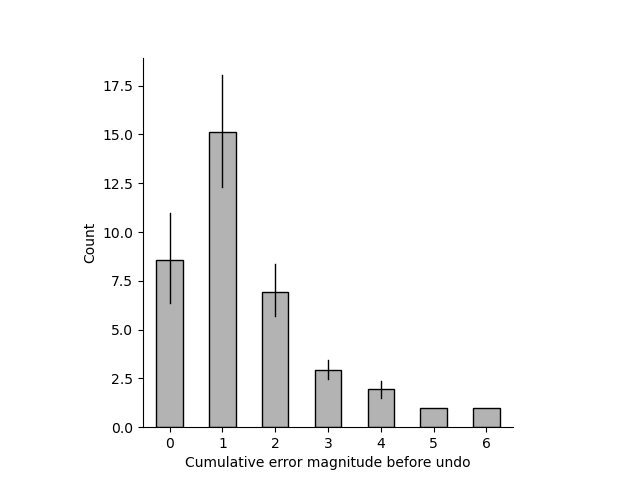

,cum_error_beginning,subjects
0,0,72
1,1,82
2,2,82
3,3,58
4,4,31
5,5,4
6,6,1


In [239]:
# plot accu_error_sub as sns barplot
%matplotlib widget

fig, axs = plt.subplots(1,1)
sns.barplot(x = 'cum_error_beginning', y = 'puzzleID', data = mas_gain_df_sub, 
            color = [.7,.7,.7],
            width=.5, linewidth=1,
            # error bar parameters
            errwidth = 1,
            errcolor = 'k',
            edgecolor = 'k',
            ax = axs)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Count')

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')
mas_gain_df_sub.groupby(['cum_error_beginning'])['subjects'].count().reset_index()

## Check the position where they "first" made errors, and whether undo terminal is that


### undo terminal is not the start city

In [211]:
accu_error_3 = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','error_beginning','category'])

for sub in range(101):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        # last undo index when it is not the start city
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_nostart:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1

            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0: # the state before first undo
                lastUndo_idx_nostart = lastUndo_idx_nostart.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_nostart,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])

        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_nostart-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error) # the number of undo terminal
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1
            elif accu_severity_error[i] > 0: # undo too little
                category[i] = 2
        
        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_3 = pd.concat([accu_error_3,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                 'category':category})])


In [212]:
accu_error_3["terminal"] = "notstart"

In [213]:
# get proportion of each category among all categories, grouped by subjects
accu_error_3_p = accu_error_3.groupby(['subjects','category']).size().unstack(fill_value=0).apply(lambda x: x/x.sum(), axis=1)
accu_error_3_p

category,0,1,2
subjects,,,
0,0.250000,0.625000,0.125000
1,0.052632,0.421053,0.526316
2,0.200000,0.400000,0.400000
4,0.000000,0.250000,0.750000
6,0.000000,0.666667,0.333333
...,...,...,...
93,0.000000,0.157895,0.842105
95,0.214286,0.285714,0.500000
96,0.312500,0.562500,0.125000


Text(0, 0.5, 'Proportion')

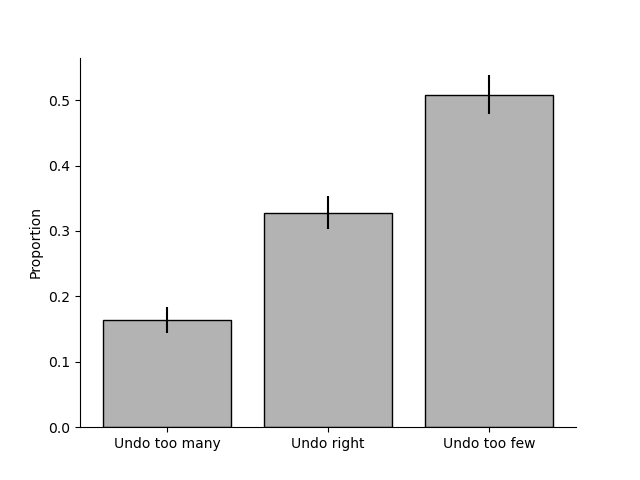

In [214]:
%matplotlib widget
plt.figure()
plt.bar(range(3), np.mean(accu_error_3_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(accu_error_3_p,axis = 0)/np.sqrt(accu_error_3_p.shape[0]))
plt.xticks([0,1,2], ['Undo too many','Undo right','Undo too few'])
plt.ylabel('Proportion')

### When undo terminal is the start city

In [215]:
# create empty dataframe
accu_error_2 = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','error_beginning','category'])

for sub in range(101):
    dat_sbj  = sc_data_choice_level.loc[(sc_data_choice_level['subjects']==sub),:].sort_values(["puzzleID","index"])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []

        dat_sbj_pzi = dat_sbj.loc[(dat_sbj['puzzleID'] == pzi),:].reset_index()    

        # last undo index when it is not the start city
        # only select rows when (dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi.lastUndo==1)&(dat_sbj_pzi.choice==0)].index
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_start:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            
            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0:
                lastUndo_idx_start = lastUndo_idx_start.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_start,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_start-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        category = [np.nan]*len(accu_severity_error)
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1

        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_2 = pd.concat([accu_error_2,pd.DataFrame({'subjects':sub,'puzzleID':pzi,'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,'category':category})])

In [216]:
accu_error_2["terminal"] = "start"


In [217]:
# get proportion of each category among all categories, grouped by subjects
accu_error_2_p = accu_error_2.groupby(['subjects','category']).size().unstack(fill_value=0).apply(lambda x: x/x.sum(), axis=1)
accu_error_2_p

category,0,1
subjects,,
0,1.000000,0.000000
1,0.000000,1.000000
2,0.360000,0.640000
3,0.500000,0.500000
4,0.181818,0.818182
...,...,...
94,0.000000,1.000000
95,0.200000,0.800000
96,0.210526,0.789474


Text(0, 0.5, 'Proportion')

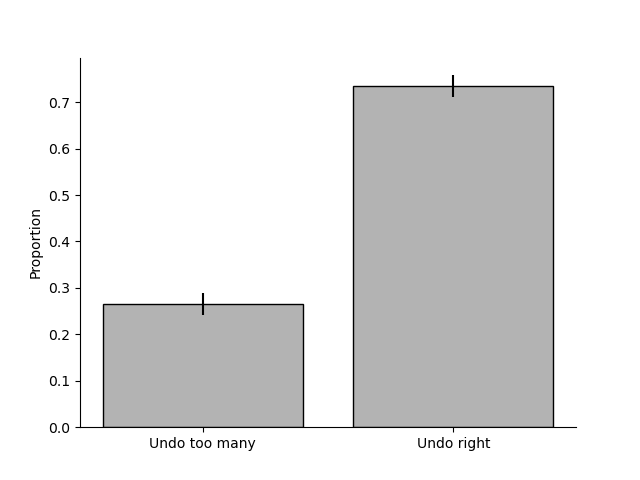

In [218]:
%matplotlib widget
plt.figure()
plt.bar(range(2), np.mean(accu_error_2_p,axis=0),
        color=[.7,.7,.7], edgecolor = 'k', 
        yerr=np.std(accu_error_2_p,axis = 0)/np.sqrt(accu_error_2_p.shape[0]))
plt.xticks([0,1], ['Undo too many','Undo right'])
plt.ylabel('Proportion')

### Total

In [219]:
# combine accu_error_2 and accu_error_3 into one dataframe
accu_error = pd.concat([accu_error_2,accu_error_3])
# calcualte the proportion of each category plus terminal, grouped by subjects
accu_error_p = accu_error.groupby(['category','terminal','subjects']).size().unstack(fill_value=0).apply(lambda x: x/x.sum())
accu_error_p = accu_error_p.T


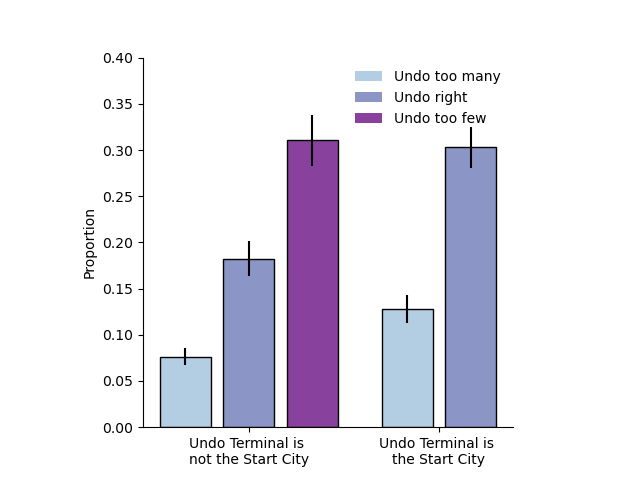

In [220]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
plt.bar(range(3), np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis=0),
        color= ["#b3cde3", "#8c96c6", "#88419d"], 
        edgecolor = 'k', 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"].shape[0]))
plt.bar([3.5,4.5], np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis=0),
        edgecolor = 'k', 
        color= ["#b3cde3", "#8c96c6"],
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"].shape[0])
               )
#plt.legend(color = ["red", "blue", "green"],
#           labels = ['Undo too many','Undo right','Undo too few'])
legend_elements = [Patch(facecolor='#b3cde3', label='Undo too many'),    
                   Patch(facecolor='#8c96c6', label='Undo right'),    
                   Patch(facecolor='#88419d', label='Undo too few')]
# create the legend
plt.legend(handles=legend_elements)


plt.xticks([1,4], ['Undo Terminal is \nnot the Start City','Undo Terminal is \nthe Start City'])
plt.ylabel('Proportion')
# 
axs.set_ylim([0,0.4])
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

# what predicts the undo terminal

## cumulative error magnitude before undo

In [221]:
accu_error_p = accu_error.groupby(['category','terminal','subjects'])['cum_error_beginning'].mean().unstack(fill_value=0)
accu_error_p = accu_error_p.T
accu_error_p

category         0                  1                   2
terminal  notstart     start notstart     start  notstart
subjects                                                 
0         1.000000  3.000000     1.20  0.000000  2.000000
1         1.000000  0.000000     1.50  2.000000  1.500000
2         1.000000  1.666667     1.50  2.562500  2.500000
3         0.000000  4.000000     0.00  3.000000  0.000000
4         0.000000  1.500000     1.00  2.333333  1.833333
...            ...       ...      ...       ...       ...
94        0.000000  0.000000     0.00  4.000000  0.000000
95        1.666667  1.000000     1.25  1.875000  1.285714
96        1.000000  1.500000     1.00  1.333333  1.000000
97        0.000000  0.000000     1.00  1.000000  2.000000
99        1.000000  1.750000     2.00  2.111111  1.333333

[90 rows x 5 columns]

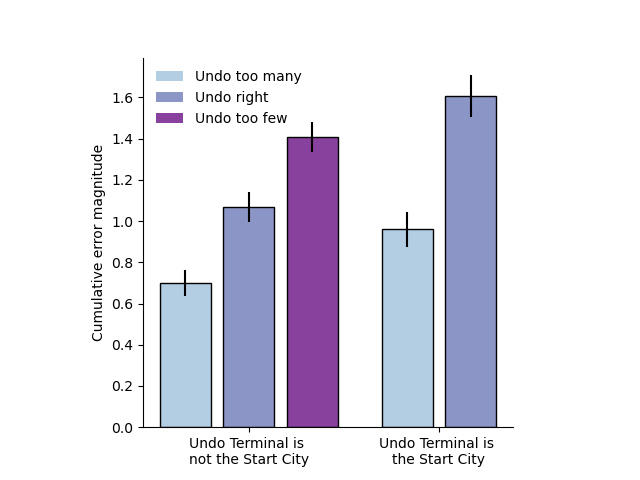

In [222]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
plt.bar(range(3), np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis=0),
        color= ["#b3cde3", "#8c96c6", "#88419d"], 
        edgecolor = 'k', 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"].shape[0]))
plt.bar([3.5,4.5], np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis=0),
        edgecolor = 'k', 
        color= ["#b3cde3", "#8c96c6"], 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"].shape[0])
               )
#plt.legend(color = ["red", "blue", "green"],
#           labels = ['Undo too many','Undo right','Undo too few'])
legend_elements = [Patch(facecolor='#b3cde3', label='Undo too many'),    
                   Patch(facecolor='#8c96c6', label='Undo right'),    
                   Patch(facecolor='#88419d', label='Undo too few')]
# create the legend
plt.legend(handles=legend_elements)


plt.xticks([1,4], ['Undo Terminal is \nnot the Start City','Undo Terminal is \nthe Start City'])
plt.ylabel('Cumulative error magnitude')
# 
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')

## error magnitude before undo

In [223]:
accu_error_p = accu_error.groupby(['category','terminal','subjects'])['error_beginning'].mean().unstack(fill_value=0)
accu_error_p = accu_error_p.T
accu_error_p

category         0               1                   2
terminal  notstart start  notstart     start  notstart
subjects                                              
0         0.000000  0.00  0.600000  0.000000  0.000000
1         0.000000  0.00  0.500000  0.500000  0.200000
2         0.000000  0.00  0.000000  0.187500  0.000000
3         0.000000  0.00  0.000000  1.000000  0.000000
4         0.000000  0.00  0.000000  0.111111  0.166667
...            ...   ...       ...       ...       ...
94        0.000000  0.00  0.000000  0.000000  0.000000
95        0.333333  0.00  0.000000  0.000000  0.000000
96        0.000000  0.25  0.222222  0.133333  0.000000
97        0.000000  0.00  1.000000  1.000000  1.000000
99        0.000000  0.00  0.000000  0.111111  0.000000

[90 rows x 5 columns]

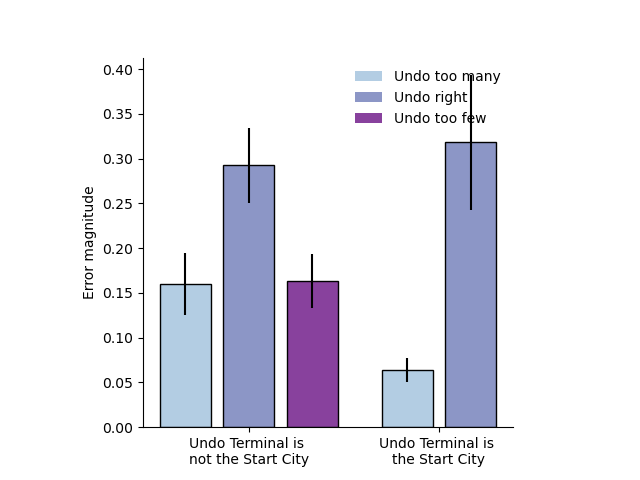

In [224]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
plt.bar(range(3), np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis=0),
        color= ["#b3cde3", "#8c96c6", "#88419d"], 
        edgecolor = 'k', 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"].shape[0]))
plt.bar([3.5,4.5], np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis=0),
        edgecolor = 'k', 
        color= ["#b3cde3", "#8c96c6"], 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"].shape[0])
               )
#plt.legend(color = ["red", "blue", "green"],
#           labels = ['Undo too many','Undo right','Undo too few'])
legend_elements = [Patch(facecolor='#b3cde3', label='Undo too many'),    
                   Patch(facecolor='#8c96c6', label='Undo right'),    
                   Patch(facecolor='#88419d', label='Undo too few')]
# create the legend
plt.legend(handles=legend_elements)


plt.xticks([1,4], ['Undo Terminal is \nnot the Start City','Undo Terminal is \nthe Start City'])
plt.ylabel('Error magnitude')
# 
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig('/Users/dbao/Desktop/figure.png', dpi=300, bbox_inches='tight')